In [1]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2

from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import os

## Loading the data

In [2]:
labels = ['with_mask', 'without_mask']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        label_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_img_arr, label_num])
            except Exception as e:
                print(e)
    return data

In [3]:
data = get_training_data('.\\train')
# test = get_training_data('./Face-Mask-Detection/test')

In [4]:
data[0]

[array([[39, 38, 36, ..., 35, 35, 35],
        [41, 38, 37, ..., 37, 37, 36],
        [42, 39, 38, ..., 41, 39, 37],
        ...,
        [72, 75, 78, ..., 73, 75, 76],
        [70, 73, 76, ..., 84, 83, 82],
        [70, 72, 75, ..., 94, 92, 90]], dtype=uint8),
 0]

## Data Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

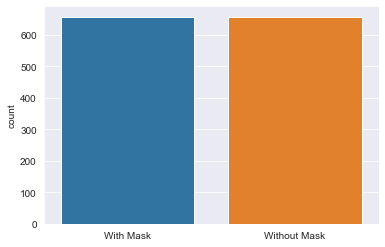

In [6]:
l = []
for i in data:
    if(i[1] == 0):
        l.append("With Mask")
    else:
        l.append("Without Mask")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'with_mask')

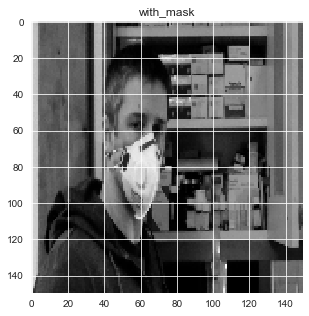

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(data[1][0], cmap='gray')
plt.title(labels[data[1][1]])

Text(0.5, 1.0, 'without_mask')

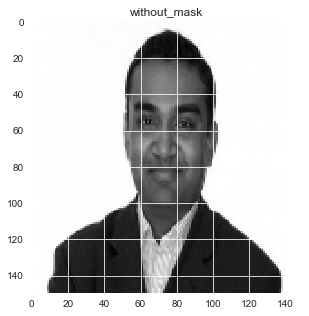

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(data[-2][0], cmap='gray')
plt.title(labels[data[-2][1]])

## Training the model

In [9]:
def get_feature_and_label(data):
    x, y = [], []
    for feature, label in data:
        x.append(feature)
        y.append(label)
    return x, y

In [10]:
x, y = get_feature_and_label(data)
# x_test, y_test = get_feature_and_label(test)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)


In [12]:
# Normalizing the data

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

In [13]:
#resize data for deep learning 

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train).reshape(-1,1)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test).reshape(-1,1)

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [15]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [16]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2, verbose=1,
    factor=0.3, min_lr=0.000001)

In [17]:
model.fit(
    datagen.flow(x_train, y_train, batch_size=10),
    epochs=12,
    validation_data=datagen.flow(x_test, y_test),
    callbacks=[learning_rate_reduction]
    )

Epoch 1/12
89/89 [==============================] - 44s 471ms/step - loss: 1.0723 - accuracy: 0.7072 - val_loss: 3.2819 - val_accuracy: 0.4908
Epoch 2/12
89/89 [==============================] - 39s 434ms/step - loss: 0.3681 - accuracy: 0.8677 - val_loss: 1.5161 - val_accuracy: 0.4908
Epoch 3/12
89/89 [==============================] - 43s 481ms/step - loss: 0.2529 - accuracy: 0.9092 - val_loss: 1.0305 - val_accuracy: 0.4263

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
89/89 [==============================] - 48s 540ms/step - loss: 0.2129 - accuracy: 0.9207 - val_loss: 2.5784 - val_accuracy: 0.4885
Epoch 5/12
89/89 [==============================] - 43s 485ms/step - loss: 0.1799 - accuracy: 0.9208 - val_loss: 0.7214 - val_accuracy: 0.6313
Epoch 6/12
89/89 [==============================] - 49s 549ms/step - loss: 0.1694 - accuracy: 0.9346 - val_loss: 0.9220 - val_accuracy: 0.6382
Epoch 7/12
89/89 [==============================] - 49s 551ms

In [18]:
loss, accuracy = model.evaluate(x_test, y_test)

print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , accuracy*100 , "%")

14/14 [==============================] - 3s 168ms/step - loss: 0.0552 - accuracy: 0.9862
Loss of the model is -  0.05524315685033798
Accuracy of the model is -  98.61751198768616 %


In [41]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")

In [45]:
y_pred[:15].reshape(-1)

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])

In [20]:
y_test[:15].reshape(-1)

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])

In [46]:
cm = confusion_matrix(y_pred, y_test)
cm

array([[221,   6],
       [  0, 207]], dtype=int64)

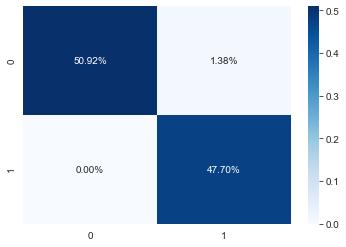

In [47]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       227
           1       0.97      1.00      0.99       207

    accuracy                           0.99       434
   macro avg       0.99      0.99      0.99       434
weighted avg       0.99      0.99      0.99       434



In [59]:
model.save('face_mask_detection.model')

INFO:tensorflow:Assets written to: face_mask_detection.model\assets
